# Chapter 04 - Example 2 

ratio-to-moving-average method.    
The trend model is a 12-month 
centered moving average and the mode for the time series is
multiplicative components model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [21]:
def read_ods(filename, columns):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=columns)
    df = df.rename(columns=columns)
  return df

### Get accuracy measures

In [5]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD


## Load the data

In [8]:
filename = "04-table-02-sales-cavanaugh-company.ods"

df = read_ods(filename, 
  {"Month": "t", "Sales": "Y_t"})

df["t"] = np.arange(1, len(df)+1)

df.head()


,t,Y_t
0,1,518
1,2,404
2,3,300
3,4,210
4,5,196


## Seasonal index table (2 years)

In [20]:
df_seasonal = df.copy()

k1 = 12
df_seasonal["mov_tot_12"] = df_seasonal["Y_t"].rolling(window=k1).sum().shift(-6)

k2 = 2
df_seasonal["mov_tot_2y"] = df_seasonal["mov_tot_12"].rolling(window=k2).sum()

df_seasonal["mov_avg_12_center"] = df_seasonal["mov_tot_2y"] / (k1*k2)

# dividing by the trend
df_seasonal["S_idx"] = df_seasonal["Y_t"] / df_seasonal["mov_avg_12_center"]

df_seasonal

,t,Y_t,mov_tot_12,mov_tot_2y,mov_avg_12_center,S_idx
0,1,518,NaN,NaN,NaN,NaN
1,2,404,NaN,NaN,NaN,NaN
2,3,300,NaN,NaN,NaN,NaN
3,4,210,NaN,NaN,NaN,NaN
4,5,196,NaN,NaN,NaN,NaN
5,6,186,4869.0,NaN,NaN,NaN
6,7,247,4964.0,9833.0,409.708333,0.602868
7,8,343,4952.0,9916.0,413.166667,0.830173
8,9,464,4925.0,9877.0,411.541667,1.127468
9,10,680,5037.0,9962.0,415.083333,1.638225


## Adjusted seasonal index

The montly seasonal indexes for each year must sum to 12, so the median for each month must be adjusted to get the final set of seasonal indexes.

### Read the full data

In [31]:
filename = "04-table-P-14-sales-cavanaugh-company.ods"

df = read_ods(filename, None)
df

,Month,2000,2001,2002,2003,2004,2005,2006
0,January,154,200,223,346,518,613,628.0
1,February,96,118,104,261,404,392,308.0
2,March,73,90,107,224,300,273,324.0
3,April,49,79,85,141,210,322,248.0
4,May,36,78,75,148,196,189,272.0
5,June,59,91,99,145,186,257,NaN
6,July,95,167,135,223,247,324,NaN
7,August,169,169,211,272,343,404,NaN
8,September,210,289,335,445,464,677,NaN
9,October,278,347,460,560,680,858,NaN


In [39]:
num_of_years = 7
num_of_rows = len(df.columns) - 1
t_arr = np.arange(12*num_of_years)

df_rows = pd.DataFrame(t_arr, columns={"t"})

Y_t_arr = np.empty(12*num_of_years)
for i in range(num_of_rows):
  column_year = 2000 + i
  Y_t_arr[12*i:12*i+12] = df[column_year].to_numpy()

df_rows["Y_t"] = Y_t_arr
#df_rows

### Compute monthly seasonal index

In [41]:
df_full_seasonal = df_rows.copy()

k1 = 12
df_full_seasonal["mov_tot_12"] = df_full_seasonal["Y_t"].rolling(window=k1).sum().shift(-6)

k2 = 2
df_full_seasonal["mov_tot_2y"] = df_full_seasonal["mov_tot_12"].rolling(window=k2).sum()

df_full_seasonal["mov_avg_12_center"] = df_full_seasonal["mov_tot_2y"] / (k1*k2)

# dividing by the trend
df_full_seasonal["S_idx"] = df_full_seasonal["Y_t"] / df_full_seasonal["mov_avg_12_center"]

#df_full_seasonal


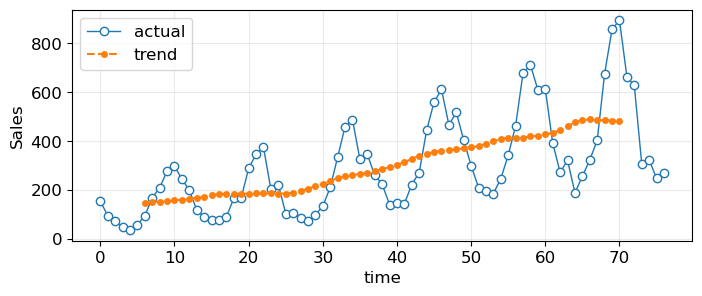

In [68]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(df_rows["t"], df_rows["Y_t"], 
  marker='o', markerfacecolor="white", 
  linestyle='-', linewidth=1, label="actual")
ax.plot(df_rows["t"], df_full_seasonal["mov_avg_12_center"],
  marker='o', markersize=4, linestyle='--', label="trend")

ax.set_xlabel("time")
ax.set_ylabel("Sales")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

In [50]:
# Create the table for montly seasonal index 
# including median and adjusted seasonal index

seasonal_idx = df_full_seasonal["S_idx"].to_numpy()

df_month_seasonal = pd.DataFrame(df["Month"])

for i in range(num_of_years):
  year_key = f"20{i:02d}"
  df_month_seasonal[year_key] = seasonal_idx[12*i:12*i+12]

seasonal_idx_median = np.empty(12)
for i in range(12):
  row_seasonal_idx = df_month_seasonal.iloc[i,1:]
  seasonal_idx_median[i] = row_seasonal_idx.median()

df_month_seasonal["Median"] = seasonal_idx_median

median_total = df_month_seasonal["Median"].sum()
print(f"multiplier: {k1/median_total}")
df_month_seasonal["Adj_S_idx"] = df_month_seasonal["Median"] * (12 / median_total)
df_month_seasonal

multiplier: 11.943674553142841


,Month,2000,2001,2002,2003,2004,2005,2006,Median,Adj_S_idx
0,January,NaN,1.207851,1.201617,1.272059,1.411124,1.431268,NaN,1.272059,1.278058
1,February,NaN,0.699951,0.559140,0.938146,1.088827,0.903139,NaN,0.903139,0.907398
2,March,NaN,0.523636,0.564148,0.785047,0.800445,0.612852,NaN,0.612852,0.615742
3,April,NaN,0.443716,0.433029,0.479456,0.551785,0.697347,NaN,0.479456,0.481717
4,May,NaN,0.423625,0.364594,0.487778,0.502940,0.396365,NaN,0.423625,0.425623
5,June,NaN,0.490346,0.459308,0.461110,0.465242,0.527992,NaN,0.465242,0.467436
6,July,0.638655,0.903720,0.597896,0.680916,0.602868,0.661731,NaN,0.650193,0.653259
7,August,1.114898,0.912691,0.888577,0.798532,0.830173,0.829995,NaN,0.859375,0.863428
8,September,1.370683,1.559703,1.346057,1.272337,1.127468,1.394798,NaN,1.358370,1.364776
9,October,1.791622,1.863087,1.796290,1.573955,1.638225,1.771202,NaN,1.781412,1.789813


### Plot seasonal indices

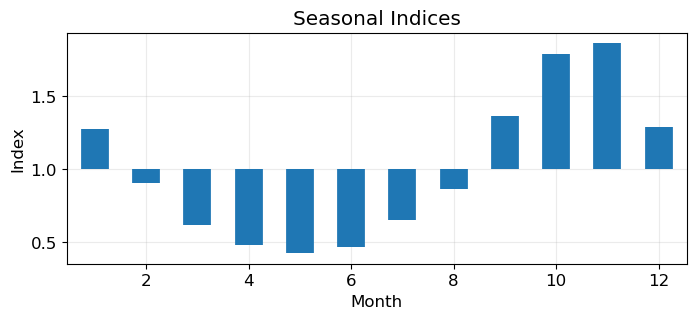

In [63]:
fig, ax = plt.subplots(figsize=(8, 3))

t_month = np.arange(12) + 1
stem_handler = ax.stem(t_month, df_month_seasonal["Adj_S_idx"],
                       bottom=12/median_total)

stem_handler[0].set_marker(None)
stem_handler[1].set_linewidth(20)
stem_handler[2].set_alpha(0)

ax.set_xlabel("Month")
ax.set_ylabel("Index")
ax.set_title("Seasonal Indices")
ax.grid("on")

plt.show(fig)

Sales for this company are periodic, with relatively low sales in the late spring and relatively high sales in the late fall.